In [1]:
import metpy.calc as mpcalc
from metpy.constants import g, Cp_d, Lv, Rd
from datetime import datetime
from siphon.simplewebservice.wyoming import WyomingUpperAir
from metpy.units import units, concatenate
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
# These functions are PR's for MetPy already

def dry_static_energy(heights, temperature):
    r"""Calculate the dry static energy of parcels.

    This function will calculate the dry static energy following the first two terms of
    equation 3.72 in [REF.

    Notes
    -----
    .. math::\text{dry static energy} = c_{pd} * T + gz

    * :math:`T` is temperature
    * :math:`z` is height

    Parameters
    ----------
    heights : array-like
        Atmospheric height profile
    temperature : array-like
        Atmospheric temperature profile

    Returns
    -------
    `pint.Quantity`
        The dry static energy.

    """

    return g * heights + Cp_d * temperature


def moist_static_energy(heights, temperature, specific_humidity):
    r"""Calculate the moist static energy of parcels.

    This function will calculate the moist static energy following equation 3.72 in [REF.

    Notes
    -----
    .. math::\text{moist static energy} = c_{pd} * T + gz + L_v q

    * :math:`T` is temperature
    * :math:`z` is height
    * :math:`q` is specific humidity

    Parameters
    ----------
    heights : array-like
        Atmospheric height profile
    temperature : array-like
        Atmospheric temperature profile
    specific_humidity : array-like
        Atmospheric specific humidity profile

    Returns
    -------
    `pint.Quantity`
        The moist static energy.

    """

    return dry_static_energy(heights, temperature) + Lv * specific_humidity


def specific_humidity_from_mixing_ratio(mixing_ratio):
    r"""Calculate the specific humidity from the mixing ratio.

    Parameters
    ----------
    mixing_ratio: `pint.Quantity`
        mixing ratio

    Returns
    -------
    `pint.Quantity`
        Specific humidity

    Notes
    -----
    Formula from [Salby1996]_ pg. 118.

    .. math:: q = \frac{w}{1+w}

    * :math:`w` is mixing ratio
    * :math:`q` is the specific humidity

    See Also
    --------
    mixing_ratio

    """
    return mixing_ratio / (1 + mixing_ratio)

In [3]:
date = datetime(2002, 11, 11, 0)
station = 'BNA'

df = WyomingUpperAir.request_data(date, station)
pressure = df['pressure'].values * units(df.units['pressure'])
temperature = df['temperature'].values * units(df.units['temperature'])
dewpoint = df['dewpoint'].values * units(df.units['dewpoint'])
heights = df['height'].values * units(df.units['height'])

# Calculate mixing ratios
q = mpcalc.mixing_ratio(mpcalc.saturation_vapor_pressure(dewpoint), pressure)
qs = mpcalc.mixing_ratio(mpcalc.saturation_vapor_pressure(temperature), pressure)

# Calculate variables to plot
s = dry_static_energy(heights, temperature).to('kJ/kg')
sv = dry_static_energy(heights, mpcalc.virtual_temperature(temperature, q)).to('kJ/kg')
h = moist_static_energy(heights, temperature, q).to('kJ/kg')
hs = moist_static_energy(heights, temperature, qs).to('kJ/kg')

In [24]:
class massEnergyPlot(object):
    """Make mass energy plots of data.
    
    This class makes mass energy plots of upper air data and
    the associated marked lines.
    
    Attributes
    ----------
    ax : `matplotlib.axes.Axes`
        The underlying Axes instance, which can be used for calling additional
        plot functions (e.g. `axvline`)
    fig : `matplotlib.figure.Figure`
        The underlying Figure instance to make addition figure manipulation easy
        
    """
    
    def __init__(self, fig=None, ax=None):
        """Create mass energy plots.
        
        Parameters
        ----------
        fig : `matplotlib.figure.Figure`, optional
            Source figure to use for plotting. If none is given, a new
            :class:`matplotlib.figure.Figure` instance will be created.
        ax : `matplotlib.axes.Axes`
            Source axis to use for plotting. If none is given, a new
            :class:`matplotlib.axes.Axes` instance will be created.
        
        """
        # Setup figure and axes if we don't have them
        if fig is None:
            fig = plt.figure(figsize=(11,8))
        if ax is None:
            ax = plt.subplot(1, 1, 1)
        self.fig = fig
        self.ax = ax
        
        # Set default axis limits
        self.ax.set_xlim(250, 400)
        self.ax.set_ylim(1050, 100)

    def isohumes(self, static_dry_energy, saturation_specific_humidity,
                 values=np.arange(10, 100, 10) * units.percent, 
                 label=True, label_y_position=800 * units.hPa, **kwargs):
        """Add lines of constant relative humidity.
        
        Plots lines of constant relative humidity as fiducials.
        
        Parameters
        ----------
        static_dry_energy : array_like
            Values of static dry energy for the data
        saturation_specific_humidity : array_like
            Values of saturation specific humidity for the data
        values : array_like, optional
            Values of relative humidity to plot
        label : boolean, optional
            Add text indicating the values of relative humidity
        label_y_position: `pint.Quanity`, optional
            Pressure coordinate of relative humidity labels
        kwargs
            Other keyword arguments to pass to :func:`~matplotlib.pyplot.plot`
        
        Returns
        -------
        list[matplotlib.lines.Line2D]
            lines plotted
        list[matplotlib.?.?]
            annotations plotted
            
        """
        plotting_style = {'linewidth': 0.5, 'linestyle': ':', 'color': 'black'}
        plotting_style.update(kwargs)
        lines = []
        annotations = []
        # Add lines of constant RH
        for rh in np.arange(10, 100, 10) * units.percent:
            line = self.ax.plot(static_dry_energy + Lv * saturation_specific_humidity * rh,
                                pressure, **plotting_style)
            lines.append(line)
            # Add labels for the RH values
            if label:
                idx = np.argmin(np.abs(pressure - label_y_position))
                label_x_position = (static_dry_energy[idx] + Lv * saturation_specific_humidity[idx] * rh).to('kJ/kg')
                annotation = self.ax.annotate(rh.m, xy=(label_x_position, label_y_position),                    
                                                    horizontalalignment='center', fontsize=8)
                annotations.append(annotation)
        return lines, annotations
                
    def shade_precipitable_water(self, pressure, moist_static_energy, 
                                 dry_static_energy, **kwargs):
        """Shade area proportional to precipitable water.
        
        Shades the area where the dry static energy of a parcel is greater than the
        moist static energy. This area is proportional to the value of precipitable
        water in the column.
        
        Parameters
        ---------
        pressure : array-like
            Atmospheric pressure profile
        moist_static_energy : array-like
            Atmospheric moist static energy profile
        dry_static_energy : array-like
            Atmospheric dry static energy profile
        kwargs
            Other keyword arguments to pass to :func:`~matplotlib.pyplot.fill_betweenx`
        
        Returns
        -------
        """
        fill_parameters = {'facecolor': 'tab:blue', 'alpha': 0.4}
        fill_parameters.update(kwargs)
        self.ax.fill_betweenx(pressure, moist_static_energy, dry_static_energy,
                              where=dry_static_energy>moist_static_energy, **fill_parameters)

    def rce_reference(self, xloc=260 * units('kJ/kg'),
                      yloc= concatenate([0, 1100] * units.hPa), label=True,
                      text_loc = (260 * units('kJ/kg'), 1045 * units.hPa)):
        """Reference line for radiative convective equilibrium.
        
        Add a reference line for plotting energy reference areas.
        
        Parameters
        ----------
        xloc : `pint.Quantity`, optional
            x-axis location of the reference line
        yloc : array-like, optional
            y-axis values to plot reference line between
        label : boolean,
            plotting of a text label annotation
        text_loc : array-like, optional
            position of the text annotation
            
        Returns
        -------
        matplotlib.lines.Line2D
            line plotted
        matplotlib.?.?
            annotation plotted
            
        """
        annotation = None
        line = self.ax.plot(np.ones((2)) * xloc, yloc, linewidth=0.5)
        if label:
            annotation = self.ax.annotate('Daily RCE', xy=text_loc, horizontalalignment='center')
        return line, annotation
    
    def radiative_cooling_reference(self, xloc=260 * units('kJ/kg')):
        x_points = concatenate([xloc, xloc - (1.3 * units('kJ/kg')), xloc - (1.3 * units('kJ/kg')), xloc, xloc])
        y_points = concatenate([1000, 1000, 200, 200, 1000]) * units.hPa
        self.ax.fill(x_points, y_points, linewidth=1, color='c', alpha=0.9)

        self.ax.annotate('Cooling $-1.3 K/d$',  xy=(xloc, 300), color='c')
        self.ax.annotate('$-10^7 J m^{-2}$', xy=(xloc, 330))
    
    def surface_flux_reference(self, xloc=260 * units('kJ/kg')):
        self.ax.fill(concatenate([xloc, xloc + 11 * units('kJ/kg'), xloc + 11 * units('kJ/kg'), xloc, xloc]),             
                concatenate([1000 , 1000   , 910    , 910, 1000] * units.hPa),             
                linewidth=1, color='orange', alpha=0.5)

        self.ax.annotate('heat flux', xy=(xloc, 890 * units.hPa), color='orange')
        self.ax.annotate('116 $W m^{-2}$', xy=(xloc, 940 * units.hPa))
        self.ax.annotate('for 1 day', xy=(xloc, 960 * units.hPa), fontsize=9)
        self.ax.annotate('=$10^7 J m^{-2}$', xy=(xloc, 990 * units.hPa))
    
    def internal_waves(self, pressure, temperature, amplitude=100 * units.m, levels=np.arange(900, 100, -100) * units.hPa):
        for level in levels:
            # index of nearest datapoint
            idx = np.argmin(np.abs(pressure - level))
            
            # Calculate temperature change when parcel is displaced
            temperature_change = (-g / Cp_d * amplitude).to('delta_degC')
            wave_temperature = concatenate([temperature[idx] + temperature_change,
                                            temperature[idx] - temperature_change])
            
            # Calculate pressure change over the parcel displacement
            #rho = (-g * pressure[idx] / (Rd  * temperature[idx])).to('kg/m^3')
            pressure_change = ((-pressure[idx] * g) / (Rd * temperature[idx])) * amplitude
            pressure_change = pressure_change.to('hPa')
            wave_pressure = concatenate([pressure[idx] + pressure_change,
                                         pressure[idx] - pressure_change])
            
            # Calculate the change in saturation mixing ratio
            specific_humidity_change = mpcalc.mixing_ratio(mpcalc.saturation_vapor_pressure(wave_temperature) ,wave_pressure)
            wave_specific_humidity = q[idx] + specific_humidity_change
            
            # Calculate moist static energy
            wave_heights = concatenate([heights[idx] + amplitude,
                                       heights[idx] - amplitude])
            wave_moist_static_energy = moist_static_energy(wave_heights, wave_temperature, wave_specific_humidity)

            
            # Plot wave annotations
            self.ax.plot(wave_moist_static_energy, wave_pressure, linewidth=3, color='tab:red')
            self.ax.plot(concatenate([s[idx], s[idx]]), wave_pressure, linewidth=3, color='tab:red')
            self.ax.plot(concatenate([h[idx], h[idx]]), wave_pressure, linewidth=3, color='tab:blue')

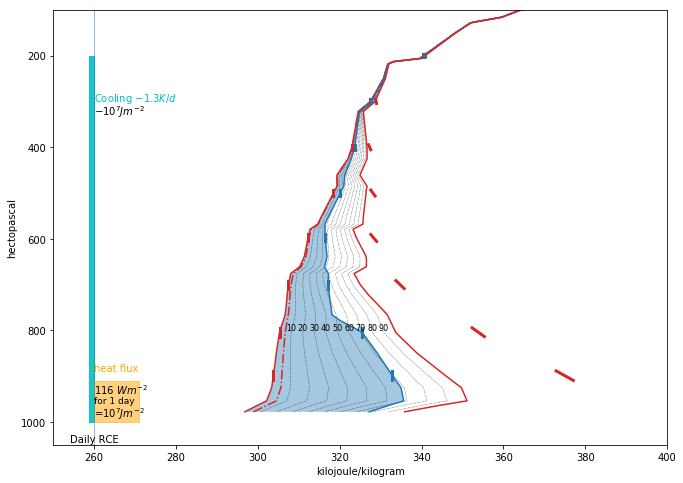

In [25]:
mep = massEnergyPlot()
#print(mep.isohumes(s, qs))
l, a = mep.isohumes(s, qs)
# Plot the sounding data
mep.ax.plot(s, pressure, color='tab:red', linewidth=1.5)
mep.ax.plot(sv, pressure, color='tab:red', linestyle='-.')
mep.ax.plot(h, pressure, color='tab:blue', linewidth=1.5)
mep.ax.plot(hs, pressure, color='tab:red', linewidth=1.5)
mep.shade_precipitable_water(pressure, s, h)
mep.rce_reference()
mep.radiative_cooling_reference()
mep.surface_flux_reference()
mep.internal_waves(pressure, temperature)

In [22]:
a

DimensionalityError: Cannot convert from 'kilojoule / kilogram' to 'dimensionless'